In [ ]:
#default_exp lightning.core

In [ ]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [ ]:
# export
from typing import Union

import albumentations as A
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning import _logger as log

from src.core import *
from src.losses import *
from src.layers import *
from src.networks import *
from src.mixmethods import *

from hydra.utils import instantiate, call
from omegaconf import OmegaConf, DictConfig

<IPython.core.display.Javascript object>

In [ ]:
import timm
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from albumentations.pytorch import ToTensorV2

<IPython.core.display.Javascript object>

In [ ]:
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [ ]:
def make_show_grid(dl):
    im, batch = next(iter(dl))
    grid = make_grid(im[:4], normalize=True).permute(1, 2, 0).data.numpy()
    plt.figure(figsize=(15, 15))
    plt.imshow(grid)

<IPython.core.display.Javascript object>

In [ ]:
# export
class CassavaLightningDataModule(pl.LightningDataModule):
    "lightning-datamodule for cassave leaf disease classification"

    def __init__(
        self,
        df_path: str,
        im_dir: str,
        curr_fold: int,
        train_augs: A.Compose,
        valid_augs: A.Compose,
        bs: int = 64,
        num_workers: int = 0,
    ):

        super().__init__()
        self.df = load_dataset(df_path, im_dir, curr_fold, True)
        self.train_augs, self.valid_augs = train_augs, valid_augs
        self.bs, self.workers = bs, num_workers
        self.curr_fold = curr_fold
        self.im_dir = im_dir
        self.logger = log

    def prepare_data(self):
        self.logger.info(f"DATA: {self.im_dir}")
        self.logger.info(f"FOLD: {self.curr_fold}  BATCH_SIZE: {self.bs}")

        self.train_df: pd.DataFrame = self.df.loc[self.df["is_valid"] == False]
        self.valid_df: pd.DataFrame = self.df.loc[self.df["is_valid"] == True]

        self.train_df = self.train_df.reset_index(inplace=False, drop=True)
        self.valid_df = self.valid_df.reset_index(inplace=False, drop=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_ds = ImageClassificationFromDf(self.train_df, self.train_augs)
            self.valid_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)
        if stage == "test" or stage is None:
            self.test_ds = ImageClassificationFromDf(self.valid_df, self.valid_augs)

    def train_dataloader(self):
        return DataLoader(
            self.train_ds, shuffle=True, batch_size=self.bs, num_workers=self.workers
        )

    def val_dataloader(self):
        return DataLoader(
            self.valid_ds, batch_size=self.bs, num_workers=self.workers, shuffle=False
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_ds, batch_size=self.bs, num_workers=self.workers, shuffle=False
        )

<IPython.core.display.Javascript object>

DATA: ../../Datasets/cassava/train_images/
FOLD: 0  BATCH_SIZE: 32


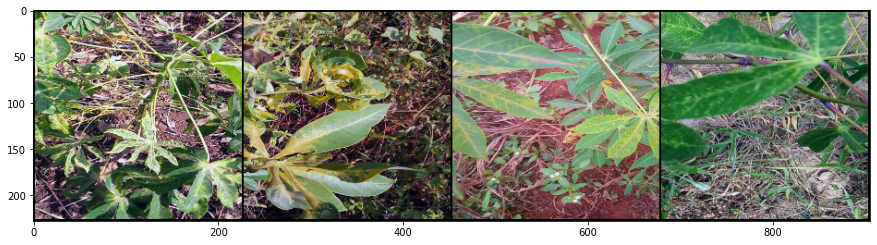

<IPython.core.display.Javascript object>

In [ ]:
train_augs = A.Compose(
    [
        A.RandomResizedCrop(224, 224, p=1.0),
        A.RandomBrightness(limit=0.1),
        A.HueSaturationValue(20, 20, 20),
        A.HorizontalFlip(),
        A.Normalize(p=1.0),
        ToTensorV2(p=1.0),
    ]
)

valid_augs = A.Compose(
    [A.Resize(224, 224, p=1.0), A.Normalize(p=1.0), ToTensorV2(p=1.0)]
)

csv = "../../leaf-disease-classification-kaggle/data/stratified-data-5folds.csv"
ims = "../../Datasets/cassava/train_images/"
dm = CassavaLightningDataModule(
    csv,
    ims,
    curr_fold=0,
    train_augs=train_augs,
    valid_augs=valid_augs,
    bs=32,
    num_workers=0,
)
dm.prepare_data()
dm.setup()
train_dl, valid_dl, test_dl = (
    dm.train_dataloader(),
    dm.val_dataloader(),
    dm.test_dataloader(),
)
make_show_grid(train_dl)

In [ ]:
# export
# TODO: add midlevel classification branch in learning.
class LightningCassava(pl.LightningModule):
    """LightningModule wrapper for `TransferLearningModel`"""

    def __init__(
        self,
        model: Union[TransferLearningModel, SnapMixTransferLearningModel],
        conf: DictConfig = None,
    ):

        super().__init__()

        self.model = model
        self._log = log
        self.accuracy = pl.metrics.Accuracy()
        self.save_hyperparameters(conf)

        try:
            mixmethod = instantiate(self.hparams["mixmethod"])
        except:
            mixmethod = None

        if mixmethod is not None:
            if isinstance(mixmethod, SnapMix):
                assert isinstance(self.model, SnapMixTransferLearningModel)

        self.mix_fn = mixmethod
        self.loss_func = instantiate(self.hparams["loss"])

        if self.mix_fn is not None:
            self._log.info(f"Mixmethod : {self.mix_fn}")

        self._log.info(f"Loss Function : {self.loss_func}")

        self.val_labels_list = []
        self.val_preds_list = []
        self.one_batch = None

    def forward(self, xb):
        return self.model(xb)

    def training_step(self, batch, batch_idx):
        x, y = batch

        if self.mix_fn is not None:
            x = self.mix_fn(x, y, self.model)
            y_hat = self(x)
            loss = self.mix_fn.loss(self.loss_func, y_hat)

        else:
            y_hat = self(x)
            loss = self.loss_func(y_hat, y)

        self.one_batch = x

        train_acc = self.accuracy(y_hat, y)

        self.log("train/loss", loss, on_epoch=True)
        self.log("train/acc", train_acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        acc = self.accuracy(y_hat, y)

        # For confusion matrix purposes
        preds = torch.argmax(y_hat, 1)
        val_labels = y.data.cpu().numpy()
        val_preds = preds.data.cpu().numpy()

        self.val_preds_list = self.val_preds_list + list(val_preds)
        self.val_labels_list = self.val_labels_list + list(val_labels)

        metrics = {"valid/loss": loss, "valid/acc": acc}

        self.log_dict(metrics)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.loss_func(y_hat, y)
        acc = self.accuracy(y_hat, y)

        metrics = {"test/loss": loss, "test/acc": acc}
        self.log_dict(metrics)

    def configure_optimizers(self):
        base_lr = self.hparams["learning_rate"]
        encoder_lr = base_lr / self.hparams["lr_mult"]
        param_list = [
            {"params": self.param_list[0], "lr": encoder_lr},
            {"params": self.param_list[1], "lr": base_lr},
        ]

        opt = instantiate(self.hparams["optimizer"], params=param_list)

        if self.hparams["scheduler"]["function"] is not None:

            if (
                self.hparams["scheduler"]["function"]["_target_"]
                == "torch.optim.lr_scheduler.OneCycleLR"
            ):
                steps = (
                    len(self.train_dataloader()) // self.trainer.accumulate_grad_batches
                )
                lr_list = [base_lr / self.hparams["lr_mult"], base_lr]
                kwargs = dict(optimizer=opt, max_lr=lr_list, steps_per_epoch=steps)

                sch = instantiate(self.hparams["scheduler"]["function"], **kwargs)

            elif (
                self.hparams["scheduler"]["function"]["_target_"] == "src.opts.FlatCos"
            ):
                steps = (
                    len(self.train_dataloader()) // self.trainer.accumulate_grad_batches
                )
                sch = instantiate(
                    self.hparams["scheduler"]["function"],
                    optimizer=opt,
                    steps_per_epoch=steps,
                )

            elif (
                self.hparams["scheduler"]["function"]["_target_"]
                == "src.opts.CosineAnnealingWarmupScheduler"
            ):
                steps = (
                    len(self.train_dataloader()) // self.trainer.accumulate_grad_batches
                )
                sch = instantiate(
                    self.hparams["scheduler"]["function"],
                    optimizer=opt,
                    steps_per_epoch=steps,
                )

            elif (
                self.hparams["scheduler"]["function"]["_target_"]
                == "src.opts.LinearSchedulerWithWarmup"
            ):
                steps = (
                    len(self.train_dataloader()) // self.trainer.accumulate_grad_batches
                )
                sch = instantiate(
                    self.hparams["scheduler"]["function"],
                    optimizer=opt,
                    steps_per_epoch=steps,
                    warmup_steps=steps,
                )

            else:
                sch = instantiate(self.hparams["scheduler"]["function"], optimizer=opt)

            # convert scheduler to lightning format
            sch = {
                "scheduler": sch,
                "monitor": self.hparams["scheduler"]["metric_to_track"],
                "interval": self.hparams["scheduler"]["scheduler_interval"],
                "frequency": 1,
            }

            self._log.info(
                f"Optimizer: {opt.__class__.__name__}  LR's: {(encoder_lr, base_lr)}"
            )
            self._log.info(f"LR Scheculer: {sch['scheduler'].__class__.__name__}")
            return [opt], [sch]

        else:
            log.info(
                f"Optimizer: {opt.__class__.__name__}  LR's: {(encoder_lr, base_lr)}"
            )
            return [opt]

    @property
    def param_list(self):
        "returns the list of parameters [params of encoder, params of fc]"
        param_list = [params(self.model.encoder), params(self.model.fc)]
        return param_list

    def load_state_from_checkpoint(self, path: str):
        "loads in the weights of the LightningModule from given checkpoint"
        checkpoint = torch.load(path, map_location=self.device)
        self.load_state_dict(checkpoint["state_dict"])
        self._log.info(f"Weights loaded from checkpoint : {path}")

    def save_model_weights(self, path: str):
        "saves weights of self.model"
        state = self.model.state_dict()
        torch.save(state, path)
        self._log.info(f"weights saved to {path}")

    def load_model_weights(self, path: str):
        "loads weights of self.model"
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict)
        self._log.info(f"weights loaded from {path}")

<IPython.core.display.Javascript object>

In [ ]:
model_hparams = dict(
    mixmethod=dict(_target_="src.mixmethods.SnapMix", alpha=5.0, conf_prob=1.0),
    loss=dict(_target_="src.losses.LabelSmoothingCrossEntropy", eps=0.1),
    learning_rate=1e-03,
    lr_mult=100,
    optimizer=dict(
        _target_="src.opts.Ranger", weight_decay=1e-02, betas=[0.95, 0.999], eps=1e-05
    ),
    scheduler=dict(
        function=dict(
            _target_="src.opts.LinearSchedulerWithWarmup",
            total_epochs=10,
            last_epoch=-1,
        ),
        metric_to_track=None,
        scheduler_interval="step",
    ),
)

cfg = OmegaConf.create(model_hparams)
print(OmegaConf.to_yaml(cfg))

mixmethod:
  _target_: src.mixmethods.SnapMix
  alpha: 5.0
  conf_prob: 1.0
loss:
  _target_: src.losses.LabelSmoothingCrossEntropy
  eps: 0.1
learning_rate: 0.001
lr_mult: 100
optimizer:
  _target_: src.opts.Ranger
  weight_decay: 0.01
  betas:
  - 0.95
  - 0.999
  eps: 1.0e-05
scheduler:
  function:
    _target_: src.opts.LinearSchedulerWithWarmup
    total_epochs: 10
    last_epoch: -1
  metric_to_track: null
  scheduler_interval: step



<IPython.core.display.Javascript object>

In [ ]:
def train_dataloader(self):
    return train_dl


LightningCassava.train_dataloader = train_dataloader

encoder = timm.create_model("resnet18", pretrained=False)

model = SnapMixTransferLearningModel(encoder, cut=-2, c=5)

model = LightningCassava(model=model, conf=cfg)
trainer = pl.Trainer()
model.trainer = trainer

opt_list, lr_scheduler_list = model.configure_optimizers()
opt, lr_scheduler = opt_list[0], lr_scheduler_list[0]["scheduler"]
opt, lr_scheduler

Mixmethod : Snampix ,conf_prob=1.0, alpha=5.0
Loss Function : LabelSmoothingCrossEntropy()
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Optimizer: Ranger  LR's: (1e-05, 0.001)
LR Scheculer: LinearSchedulerWithWarmup


(Ranger (
 Parameter Group 0
     N_sma_threshhold: 5
     alpha: 0.5
     betas: [0.95, 0.999]
     eps: 1e-05
     initial_lr: 1e-05
     k: 6
     lr: 0.0
     step_counter: 0
     weight_decay: 0.01
 
 Parameter Group 1
     N_sma_threshhold: 5
     alpha: 0.5
     betas: [0.95, 0.999]
     eps: 1e-05
     initial_lr: 0.001
     k: 6
     lr: 0.0
     step_counter: 0
     weight_decay: 0.01
 ),
 <torch.optim.lr_scheduler.LambdaLR at 0x7fe5104c77d0>)

<IPython.core.display.Javascript object>

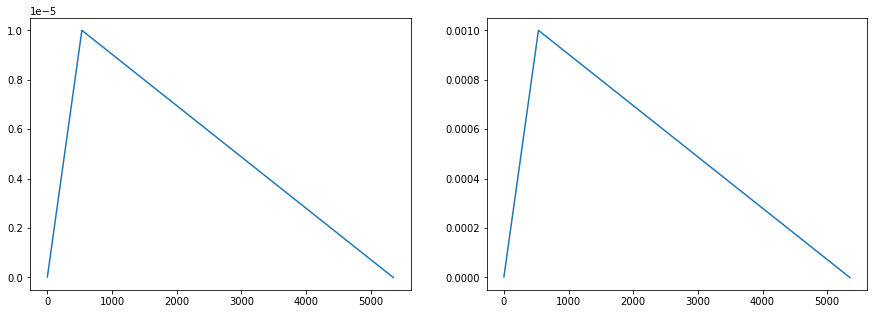

<IPython.core.display.Javascript object>

In [ ]:
lr0 = []
lr1 = []

for e in range(10):
    for idx in range(len(train_dl)):
        opt.step()
        lr_scheduler.step()
        lr0.append(lr_scheduler.get_lr()[0])
        lr1.append(lr_scheduler.get_lr()[1])


_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax1.plot(lr0)
ax2.plot(lr1)

In [ ]:
# export
# @TODO: Add Snapmix support
class LightningVisionTransformer(pl.LightningModule):
    """LightningModule wrapper for `VisionTransfer`"""

    def __init__(self, model: VisionTransformer, conf: DictConfig = None):
        super().__init__()
        self.model = model
        self._log = log
        self.accuracy = pl.metrics.Accuracy()
        self.save_hyperparameters(conf)

        try:
            mixmethod = instantiate(self.hparams["mixmethod"])
        except:
            mixmethod = None

        if mixmethod is not None:
            assert not isinstance(
                mixmethod, SnapMix
            ), "Snapmix not supported in Vision Transformer"

        self.mix_fn = mixmethod
        self.loss_func = instantiate(self.hparams["loss"])

        if self.mix_fn is not None:
            self._log.info(f"Mixmethod : {self.mix_fn}")

        self._log.info(f"Loss Function : {self.loss_func}")

        self.val_labels_list = []
        self.val_preds_list = []
        self.one_batch = None

    def forward(self, xb):
        return self.model(xb)

    def training_step(self, batch, batch_idx):
        x, y = batch

        if self.mix_fn is not None:
            x = self.mix_fn(x, y, self.model)
            y_hat = self(x)
            loss = self.mix_fn.loss(self.loss_func, y_hat)

        else:
            y_hat = self(x)
            loss = self.loss_func(y_hat, y)

        self.one_batch = x

        train_acc = self.accuracy(y_hat, y)

        self.log("train/loss", loss, on_epoch=True)
        self.log("train/acc", train_acc, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_func(y_hat, y)
        acc = self.accuracy(y_hat, y)

        # For confusion matrix purposes
        preds = torch.argmax(y_hat, 1)
        val_labels = y.data.cpu().numpy()
        val_preds = preds.data.cpu().numpy()

        self.val_preds_list = self.val_preds_list + list(val_preds)
        self.val_labels_list = self.val_labels_list + list(val_labels)

        metrics = {"valid/loss": loss, "valid/acc": acc}

        self.log_dict(metrics)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        loss = self.loss_func(y_hat, y)
        acc = self.accuracy(y_hat, y)

        metrics = {"test/loss": loss, "test/acc": acc}
        self.log_dict(metrics)

    def configure_optimizers(self):
        base_lr = self.hparams["learning_rate"]
        encoder_lr = base_lr / self.hparams["lr_mult"]
        param_list = [
            {"params": self.param_list[0], "lr": encoder_lr},
            {"params": self.param_list[1], "lr": base_lr},
        ]

        opt = instantiate(self.hparams["optimizer"], params=param_list)

        if self.hparams["scheduler"]["function"] is not None:

            if (
                self.hparams["scheduler"]["function"]["_target_"]
                == "torch.optim.lr_scheduler.OneCycleLR"
            ):
                steps = (
                    len(self.train_dataloader()) // self.trainer.accumulate_grad_batches
                )
                lr_list = [base_lr / self.hparams["lr_mult"], base_lr]
                kwargs = dict(optimizer=opt, max_lr=lr_list, steps_per_epoch=steps)

                sch = instantiate(self.hparams["scheduler"]["function"], **kwargs)

            elif (
                self.hparams["scheduler"]["function"]["_target_"] == "src.opts.FlatCos"
            ):
                steps = (
                    len(self.train_dataloader()) // self.trainer.accumulate_grad_batches
                )
                sch = instantiate(
                    self.hparams["scheduler"]["function"],
                    optimizer=opt,
                    steps_per_epoch=steps,
                )

            elif (
                self.hparams["scheduler"]["function"]["_target_"]
                == "src.opts.CosineAnnealingWarmupScheduler"
            ):
                steps = (
                    len(self.train_dataloader()) // self.trainer.accumulate_grad_batches
                )
                sch = instantiate(
                    self.hparams["scheduler"]["function"],
                    optimizer=opt,
                    steps_per_epoch=steps,
                )

            elif (
                self.hparams["scheduler"]["function"]["_target_"]
                == "src.opts.LinearSchedulerWithWarmup"
            ):
                steps = (
                    len(self.train_dataloader()) // self.trainer.accumulate_grad_batches
                )
                sch = instantiate(
                    self.hparams["scheduler"]["function"],
                    optimizer=opt,
                    steps_per_epoch=steps,
                    warmup_steps=steps,
                )

            else:
                sch = instantiate(self.hparams["scheduler"]["function"], optimizer=opt)

            # convert scheduler to lightning format
            sch = {
                "scheduler": sch,
                "monitor": self.hparams["scheduler"]["metric_to_track"],
                "interval": self.hparams["scheduler"]["scheduler_interval"],
                "frequency": 1,
            }

            self._log.info(
                f"Optimizer: {opt.__class__.__name__}  LR's: {(encoder_lr, base_lr)}"
            )
            self._log.info(f"LR Scheculer: {sch['scheduler'].__class__.__name__}")
            return [opt], [sch]

        else:
            log.info(
                f"Optimizer: {opt.__class__.__name__}  LR's: {(encoder_lr, base_lr)}"
            )
            return [opt]

    @property
    def param_list(self):
        "returns the list of parameters [params of encoder, params of fc]"
        model_params = params(self.model)[:-2]
        head_params = params(self.model.model.head)
        param_list = [model_params, head_params]
        return param_list

    def load_state_from_checkpoint(self, path: str):
        "loads in the weights of the LightningModule from given checkpoint"
        checkpoint = torch.load(path, map_location=self.device)
        self.load_state_dict(checkpoint["state_dict"])
        self._log.info(f"Weights loaded from checkpoint : {path}")

    def save_model_weights(self, path: str):
        "saves weights of self.model"
        state = self.model.state_dict()
        torch.save(state, path)
        self._log.info(f"weights saved to {path}")

    def load_model_weights(self, path: str):
        "loads weights of self.model"
        state_dict = torch.load(path)
        self.model.load_state_dict(state_dict)
        self._log.info(f"weights loaded from {path}")

<IPython.core.display.Javascript object>

In [ ]:
model_hparams = dict(
    mixmethod=dict(_target_=None),
    loss=dict(_target_="src.losses.LabelSmoothingCrossEntropy", eps=0.1),
    learning_rate=1e-03,
    lr_mult=100,
    optimizer=dict(
        _target_="torch.optim.AdamW", weight_decay=1e-02, betas=[0.95, 0.999], eps=1e-05
    ),
    scheduler=dict(
        function=dict(
            _target_="src.opts.LinearSchedulerWithWarmup",
            total_epochs=10,
            last_epoch=-1,
        ),
        metric_to_track=None,
        scheduler_interval="step",
    ),
)

cfg = OmegaConf.create(model_hparams)

<IPython.core.display.Javascript object>

In [ ]:
lit_model = LightningVisionTransformer(model, model_hparams)

Loss Function : LabelSmoothingCrossEntropy()


<IPython.core.display.Javascript object>

In [ ]:
def train_dataloader(self):
    return train_dl


LightningVisionTransformer.train_dataloader = train_dataloader

encoder = timm.create_model("vit_base_patch16_224", pretrained=True)
model = VisionTransformer(encoder=encoder, c=5)
lit_model = LightningVisionTransformer(model, model_hparams)

trainer = pl.Trainer()
lit_model.trainer = trainer

opt_list, lr_scheduler_list = lit_model.configure_optimizers()
opt, lr_scheduler = opt_list[0], lr_scheduler_list[0]["scheduler"]

Loss Function : LabelSmoothingCrossEntropy()
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
Optimizer: AdamW  LR's: (1e-05, 0.001)
LR Scheculer: LinearSchedulerWithWarmup


<IPython.core.display.Javascript object>

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_mixmethods.ipynb.
Converted 02_losses.ipynb.
Converted 03_layers.ipynb.
Converted 03a_networks.ipynb.
Converted 04_optimizers_schedules.ipynb.
Converted 05_lightning.core.ipynb.
Converted 05a_lightning.callbacks.ipynb.
Converted 06_fastai.core.ipynb.
Converted index.ipynb.


<IPython.core.display.Javascript object>